In [1]:
import boto3
import statistics
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

### Functions

In [16]:
def get_epochs_for_tfjob(tfjob_name):
    tfjob_epoch_objects = set()
    client = boto3.client('s3', endpoint_url='https://s3.cern.ch')
    for key in client.list_objects(Bucket='dejan')['Contents']:
        if tfjob_name in key['Key']:
            object_name = key['Key']
            tfjob_epoch_objects.add(object_name)
            
    return tfjob_epoch_objects

def parse_epoch_file(epoch_filename, client):
    obj = client.get_object(Bucket='dejan', Key=epoch_filename)
    lines = obj['Body'].read().decode()
    lines_list = lines.split('\n')

    epoch_metrics = {}
    epoch_metrics['batch_times'] = []
    epoch_metrics['timestamp'] = epoch_filename[-23:-4]
    for item in lines_list:
        if item == '':
            continue
        
        split_item = item.split('=')
        metric_name = split_item[0]
        metric_value = split_item[1]
        
        if 'time-batch' in metric_name:
            epoch_metrics['batch_times'].append(metric_value)
        else:
            epoch_metrics[metric_name] = metric_value
    
    return epoch_metrics

def filter_by(tfjob_info, name, filter_value):
    res_dict = {}
    for tfjob_id, tfjob_value in tfjob_info.items():
        for key in tfjob_value.keys():
            if key == name and tfjob_value[key] == filter_value:
                res_dict[tfjob_id] = tfjob_value
    
    return res_dict

def parse_tfjob_epoch_metrics(tfjobs_run_info, tfjob_ids, client):
    for tfjob_id in tfjob_ids:
        if not tfjob_id in tfjobs_run_info:
            tfjobs_run_info[tfjob_id] = {}

        tfjob_epochs = get_epochs_for_tfjob(tfjob_id)
        tfjobs_run_info[tfjob_id]['epoch'] = {}
        for epoch_filename in tfjob_epochs:
            if 'params' in epoch_filename:
                continue
            
            epoch_number = epoch_filename.split('epoch')[1].split('-')[1]
            epoch_metrics = parse_epoch_file(epoch_filename, client)
            
            if 'batch-size-per-replica' in epoch_metrics.keys():
                tfjobs_run_info[tfjob_id]['batch-size-per-replica'] = epoch_metrics['batch-size-per-replica']
                del epoch_metrics['batch-size-per-replica']
            if 'num_replicas_in_sync' in epoch_metrics.keys():
                tfjobs_run_info[tfjob_id]['num_replicas_in_sync'] = epoch_metrics['num_replicas_in_sync']
                del epoch_metrics['num_replicas_in_sync']
            if 'n_workers' in epoch_metrics.keys():
                tfjobs_run_info[tfjob_id]['n_workers'] = epoch_metrics['n_workers']
                del epoch_metrics['n_workers']
            
            tfjobs_run_info[tfjob_id]['epoch'][epoch_number] = epoch_metrics
            
def get_metrics(tfjobs_run_info, metric_name):
    metrics = []
    for tfjob_id, tfjob_value in tfjobs_run_info.items():
        metrics_job = []
        for epoch_index in sorted(tfjob_value['epoch'].keys()):
            metrics_job.append(tfjob_value['epoch'][epoch_index][metric_name])
        metrics.append(metrics_job)
        
    return metrics

def get_metrics_for_job(tfjobs_run_info, tfjob_id, metric_name):
    metrics = []

    for epoch_index in sorted(tfjobs_run_info[tfjob_id]['epoch'].keys()):
        metrics.append(tfjobs_run_info[tfjob_id]['epoch'][epoch_index][metric_name])
        
    return metrics

def get_average_from_index(lst, from_index=0):
    float_list = []
    for el in lst:
        float_list.append(float(el))
    return statistics.mean(float_list[from_index:])

def make_json_single_layer(job_id, json_record):
    result = {}
    result['bucket_id'] = job_id
    for key, value in json_record[job_id].items():
        if key == 'epoch':
            continue
        result[key] = value
    
    result['n_epochs'] = len(json_record[job_id]['epoch'].keys())
    total_train_time = 0
    total_test_time = 0
    
    for epoch_n in sorted(json_record[job_id]['epoch'].keys()):
        epoch_res = json_record[job_id]['epoch'][epoch_n]
        if int(epoch_n) != 0:
            total_train_time += float(json_record[job_id]['epoch'][epoch_n]['train-epoch-time'])
            total_test_time += float(json_record[job_id]['epoch'][epoch_n]['test-epoch-time'])
            
        for metric_name, metric_value in epoch_res.items():
            single_layer_key = 'epoch-' + str(epoch_n) + '_' + metric_name
            result[single_layer_key] = metric_value
    
    result['average_train_time'] = round(total_train_time / (int(result['n_epochs']) - 1), 2)
    result['average_test_time'] = round(total_test_time / (int(result['n_epochs']) - 1), 2)
    
    result_refined = {}
    for key, value in result.items():
        new_key = key.replace('-', '_')
        result_refined[new_key] = value
    
    return result_refined

def make_job_list_single_layer(job_dict):
    result = []
    for job_id in job_dict.keys():
        json_single_layer = make_json_single_layer(job_id, job_dict)
        result.append(json_single_layer)
    return result

def convert_json_to_pandas(json_record):
    json_single_layer = make_job_list_single_layer(json_record)
    df = pd.DataFrame(json_single_layer)
    return df

### Read Current

In [10]:
def get_tfjob_ids(client):
    tfjob_ids = set()
    client = boto3.client('s3', endpoint_url='https://s3.cern.ch')
    for key in client.list_objects(Bucket='dejan')['Contents']:
        if 'tfjob-id' in key['Key'] and ('12-16' in key['Key']):
            object_name = key['Key']
            tf_job_id = object_name[9:45]
            tfjob_ids.add(tf_job_id)
            
    return tfjob_ids

def read_job():
    client = boto3.client('s3', endpoint_url='https://s3.cern.ch')
    tfjobs_run_info = {}
    tfjob_ids = get_tfjob_ids(client)
    parse_tfjob_epoch_metrics(tfjobs_run_info, tfjob_ids, client)
    print(len(tfjobs_run_info.keys()))
    
    return tfjobs_run_info

In [11]:
def add_jobs_info(jobs, key, value):
    for job_key in jobs.keys():
        jobs[job_key][key] = value

### Script

In [29]:
current_jobs = read_job()
print(len(current_jobs))
print(current_jobs.keys())

1
1
dict_keys(['8bfd84c0-1af3-4286-b4b9-06a35ec16542'])


In [30]:
add_jobs_info(current_jobs, 'device', 'gpu-v100')
add_jobs_info(current_jobs, 'prefetch', 'yes')
add_jobs_info(current_jobs, 'cache', 'no')
add_jobs_info(current_jobs, 'nodes', '4')
add_jobs_info(current_jobs, 'gpus_per_node', '4')

In [31]:
df_current_jobs = convert_json_to_pandas(current_jobs)
print(len(df_current_jobs.columns))

1212


### Plot Metrics

In [32]:
def get_metrics_for_all_epochs(df, metrics):
    columns = [x for x in df.columns if metrics in x]
    filtered_df = df[columns]
    return filtered_df

In [39]:
metrics = 'generator_train_binary_loss'
all_jobs_df = df_current_jobs
filtered_df = get_metrics_for_all_epochs(all_jobs_df, metrics)

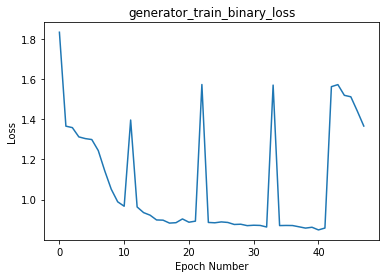

In [40]:
row = list(filtered_df.iloc[0].astype(float))
plt.plot(row)
plt.title(metrics)
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.savefig('results/' + metrics + '_after_' + str(len(row)) + '_epochs', dpi=150)
plt.show()
#filtered_df

In [ ]:
total = 124987
print((124987 % 16) / 124987 * 100 * 32)
print((124987 % 32) / 124987 * 100 * 32)
print((124987 % 48) / 124987 * 100 * 32)
print((124987 % 64) / 124987 * 100 * 32)
print((124987 % 80) / 124987 * 100 * 32)
print((124987 % (96*128)) / 124987 * 100)